In [155]:
def importData():
    from sklearn import datasets
    dataset = datasets.fetch_california_housing(as_frame = True)

    from sklearn.preprocessing import StandardScaler
    from sklearn.model_selection import train_test_split
    import numpy as np
    np.random.seed(1)

    dataset.frame_normalized = StandardScaler().fit_transform(dataset.frame)
    # We drop Longitude as well since Latitude has enough information
    X = dataset.frame_normalized[:,0:len(dataset.frame.columns) - 2]
    y = dataset.frame_normalized[:,len(dataset.frame.columns) - 1]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 9)
    X_train = np.insert(X_train, 0, np.ones(X_train.shape[0]), axis=1)
    X_test = np.insert(X_test, 0, np.ones(X_test.shape[0]), axis=1)

    return X_train, y_train, X_test, y_test

In [340]:
import numpy as np

def dot(W, x):
    value = np.dot(W, x)

    def vjp(u):
        vjp_wrt_W = np.outer(u, x) 
        vjp_wrt_x = W.T.dot(u)
        return vjp_wrt_x, vjp_wrt_W
        
    return value, vjp

def relu(x):
    value = np.maximum(0, x)

    def vjp(u):
        # gdash = lambda y: 1 if y>=0 else 0
        gdash = (x>0).reshape(-1,1)
        # gdash = np.vectorize(gdash)
        # vjp_wrt_x = u*gdash(x)
        vjp_wrt_x = u*gdash
        return vjp_wrt_x,  
        # The comma is important!
    
    return value, vjp

def initialiseMLP_random(inputfeatures, layers, unif=False, verbose=False):
    dims = np.random.choice([i for i in range(2,8)], layers)
    if unif:
        W = [np.random.uniform(-1, 1, size=(dims[0], inputfeatures))]
    else:
        W = [np.array(np.random.rand(dims[0], inputfeatures))]
    for i in range(1, len(dims)):
        if unif:
            Wi = np.random.uniform(-1, 1, size=(dims[i], dims[i-1]))
        else:
            Wi = np.array(np.random.rand(dims[i], dims[i-1]))
        W.append(Wi)

    W.reverse()
    if unif:
        x = np.random.uniform(-1, 1, inputfeatures)
        u = np.random.uniform(-1, 1, dims[-1])
    else:
        x = np.random.uniform(0, 1, inputfeatures)
        u = np.random.uniform(0, 1, dims[-1])

    if verbose:
        print("u=", np.shape(u))
        for i in range(len(W)):
            print("W{i}=".format(i=i), np.shape(W[i]))
        print("x=", np.shape(x))

    return x, W, u

def mlp2(x, W):
    """
    input: 
        x = input data
        W = list of weight matrices, W = [Wk, ..., W3, W2, W1]
    formula:
        y = W2.q(W1.x)
    returns:
        value = evaluated value according to formula
        vjp = tuple of vjp's in order x, W
    """
    W2, W1 = W
    a, vjp_dot1 = dot(W1, x)
    b, vjp_relu = relu(a)
    value, vjp_dot2 = dot(W2, b)

    def vjp(u):
        vjp_wrt_b, vjp_wrt_W2 = vjp_dot2(u)
        vjp_wrt_a, = vjp_relu(vjp_wrt_b)
        vjp_wrt_x, vjp_wrt_W1 = vjp_dot1(vjp_wrt_a) 

        return vjp_wrt_x, [vjp_wrt_W2, vjp_wrt_W1]
    return value, vjp

def mlpk(x, W): #W = [Wk, ..., W3, W2, W1]
    if (len(W)>=3):
        value, vjp_1 = mlpk(x, W[1:len(W)])
    else:
        return mlp2(x, [W[-2], W[-1]])
    
    value, vjp_2 = relu(value)
    value, vjp_3 = dot(W[0], value)

    def vjp(u):
        vjp_wrt_x, vjp_wrt_Wk = vjp_3(u)
        vjp_wrt_x, = vjp_2(vjp_wrt_x)
        vjp_wrt_x, *vjp_wrt_W = vjp_1(vjp_wrt_x)
        vjp_wrt_W = vjp_wrt_W[0]
        vjp_wrt_W.insert(0, vjp_wrt_Wk)
        return vjp_wrt_x, vjp_wrt_W

    return value, vjp

def squared_loss(y_pred, y):
    residual = y_pred - y
    def vjp(u):
        vjp_y_pred = u*(1*residual)
        vjp_y = u*(-1*residual)
        return vjp_y_pred, vjp_y
    value = 0.5 * np.sum(residual ** 2) / y_pred.shape[0]
    return value, vjp

def loss_i(i, X, y, W):
    x = X[i] # np.reshape(X[i], (X.shape[1],))
    pred_value, predicted_vjp = mlpk(x, W)
    loss_value, loss_vjp = squared_loss(pred_value, y[i])
    value = loss_value

    def vjp(u):
        vjp_y, vjp_y_pred = loss_vjp(u)
        vjp_x, vjp_W = predicted_vjp(vjp_y_pred)
        return vjp_x, vjp_y, vjp_W
    
    return value, vjp

In [330]:
def SGD(niter, step, W, X_train, y_train):
    n, d = X_train.shape
    loss_evol = []

    for it in range(niter):
        if (it%n == 0):
            print(f'Epoch {it//n}', end='\r')
        index = np.random.choice(n, 1)[-1]

        vali, vjpi = loss_i(index, X_train, y_train, W)
        u = np.array([1]).reshape(-1,1)
        vjp_wrtx, vjp_wrty, vjp_wrtW = vjpi(u)

        for k in range(len(W)):
            W[k] = W[k] - (1/n)*vjp_wrtW[k]*step
    
        loss_evol.append(vali/n)

    return loss_evol


In [313]:
X_train, y_train, X_test, y_test = importData()
n, d = X_train.shape

In [314]:
innerdim = 5
W0 = np.random.randn(innerdim, d)        #np.ones((innerdim, d)) #   
W1 = np.ones((innerdim, innerdim)) #np.random.randn(innerdim, innerdim)    
W2 = np.random.randn(1, innerdim)           #np.ones((1, innerdim)) 
W = [W2, W1, W0]
print([i.shape for i in W])

[(1, 5), (5, 5), (5, 8)]


In [315]:
def f_rec(x,W):
    if len(W)==1:
        temp = np.dot(W, x).reshape(-1)
        return temp
    temp = np.dot(W[0], np.maximum(f_rec(x, W[1:]), 0))
    return temp

In [316]:
x = X_train[int(np.random.choice(n, 1))]
val, vjp = mlpk(x, W)
assert(np.allclose(val, f_rec(x, W), rtol=1e-8)), 'values not equal'
print("Pass: Equal Values")

g = lambda x, eps, e: ( (f_rec(x+eps*e, W) - f_rec(x, W)) / eps )
eps = 1e-4
e = np.eye(1, 8, 0).reshape(-1)

findiff = np.zeros(len(x))
for i in range(len(x)):
    findiff[i] = g(x, eps, np.eye(1,8, i).reshape(-1))

#VJP with ei extracts ith row
u = np.array([1]).reshape(-1,1)
calculated_vjpX, calculated_vjpW = vjp(u)
print([i.shape for i in calculated_vjpW])

assert(np.allclose(findiff, calculated_vjpX.reshape(-1), rtol=1e-6)), "vjp's not equal"
print("Pass: Equal VJP's")

Pass: Equal Values
[(1, 5), (5, 5), (5, 8)]
Pass: Equal VJP's


In [349]:
f_loss = lambda y, y_pred: 0.5 * np.sum((y-y_pred) ** 2)# / y_pred.shape[0]
g = lambda x, x_, eps, e: ( (f_loss(x+eps*e, x_) - f_loss(x, x_)) / eps )

np.random.seed(1)
index = int(np.random.choice(n, 1))
vali, vjpi = loss_i(index, X_train, y_train, W)
u = np.array([1]).reshape(-1,1)
vjp_wrtx, vjp_wrty, vjp_wrtW = vjpi(u)

assert(np.allclose(vali, f_loss(-0.61582505, y_train[index]), rtol=1e-6))
print('Equal Values')

g(-0.61582505, y_train[index], 1e-4, 1)
vjp_wrtx

predvalue =  [-0.61582505]
loss value =  0.09385311103820665
Equal Values


array([[ 0.06015479],
       [-0.10901783],
       [-0.04623186],
       [-0.051956  ],
       [-0.0585227 ],
       [-0.01415905],
       [ 0.1305428 ],
       [ 0.00312685]])

In [338]:
epochs = 10
errs = SGD(niter=n*epochs, step=1e-10, W=W, X_train=X_train, y_train=y_train)

predvalue =  [-0.27578532]
predvalue =  [-0.36015828]
predvalue =  [-0.82681194]
predvalue =  [-0.38587988]
predvalue =  [-0.54934788]
predvalue =  [-0.28715462]
predvalue =  [-0.18644534]
predvalue =  [-0.21774202]
predvalue =  [-0.76066834]
predvalue =  [-0.49862754]
predvalue =  [-0.43656927]
predvalue =  [-1.23176865]
predvalue =  [-0.04889874]
predvalue =  [-0.77195785]
predvalue =  [-0.35459738]
predvalue =  [-0.71137066]
predvalue =  [-0.40613247]
predvalue =  [-0.49842165]
predvalue =  [-0.51225898]
predvalue =  [-0.62029117]
predvalue =  [-0.14965418]
predvalue =  [-0.40784716]
predvalue =  [-0.40074244]
predvalue =  [-0.17243082]
predvalue =  [-0.4333722]
predvalue =  [-0.33968837]
predvalue =  [-0.30096235]
predvalue =  [-0.47612938]
predvalue =  [-0.15218601]
predvalue =  [-0.70578059]
predvalue =  [-0.6548982]
predvalue =  [-0.74633288]
predvalue =  [-0.47100819]
predvalue =  [-0.21996861]
predvalue =  [-0.47715608]
predvalue =  [-0.85591475]
predvalue =  [-0.61431532]
pre

KeyboardInterrupt: 

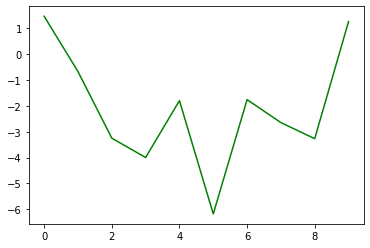

In [309]:
import matplotlib.pyplot as plt
t = np.linspace(0, epochs-1, epochs)
plt.plot(np.log(errs[::n]), 'g');
# plt.xticks(t[::2]);

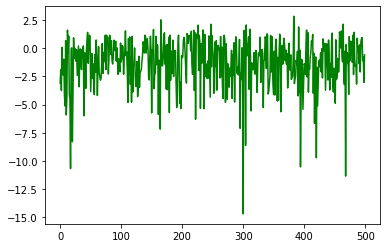

In [7]:
def SGD_minibatch(niter, step, W, X_train, y_train, batchsize):
    n, d = X_train.shape
    loss_evol = []

    for it in range(niter):
        index = np.random.choice(n, batchsize)
        loss = 0
        grad = []
        for b in range(batchsize):
            vali, vjpi = loss_i(index[b], X_train, y_train, W)
            vjp_wrtx, vjp_wrty, vjp_wrtW = vjpi(1)

            loss += vali
            grad.append(vjp_wrtW)
        
        loss = loss / batchsize
        for l in range(len(W)):
            for j in range(1,len(grad)):
                grad[0][l] += grad[j][l]/batchsize
        
        #averaging
        grad = grad[0]
        # grad = [g/batchsize for g in grad]

        for k in range(len(W)):
            W[k] = W[k] - grad[k]*step
    
        loss_evol.append(vali)

    return loss_evol

errs = SGD_minibatch(niter=500, step=1e-100, W=W, X_train=X_train, y_train=y_train, batchsize=3)
plt.plot(np.log(errs), 'g');